<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/total_auction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
!pip install catboost

     |████████████████████████████████| 69.2MB 43kB/s 


In [2]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from xgboost import XGBRegressor
import catboost as ctb
from catboost import CatBoostRegressor

import joblib
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!gdown --id 1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU

Downloading...
From: https://drive.google.com/uc?id=1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU
To: /content/purchase_plans.csv
5.52MB [00:00, 86.2MB/s]


#Обработка данных

Считывание данных о заявках

In [95]:
contract_path = 'purchase_plans.csv'
dtypes = {'plan_number' : 'category', 
          'customer_legal_form' : 'category', 
          'positionNumber' : 'category', 
          'product_info' : 'category',
          'publicDiscussion' : 'category',
          'isEnergyServiceContract': 'category',
          'OKPD': 'category'}
data = pd.read_csv(contract_path, dtype = dtypes)
gc.collect()

data.head()

,plan_number,customer_legal_form,positionNumber,positionCanceled,publicDiscussion,total,isEnergyServiceContract,time,OKPD,log_total
0,201801133000253003,75404,201801133000253003000150,False,false,97522.23,false,44,95.12.10.000,11.487836
1,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755
2,201901133000074001,75404,201901133000074001000001,False,false,3117.87,false,365,19.20.21.125,8.044905
3,201901133000089001,75404,201901133000089001000016,False,false,16000.00,false,365,61.10.11.110,9.680344
4,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755


#Корреляция ОКПД с ценой

In [ ]:
data['total'].describe()

count    4.920400e+04
mean     3.033807e+06
std      1.161167e+08
min      1.000000e-02
25%      2.800000e+04
50%      8.756000e+04
75%      2.999925e+05
max      7.154803e+09
Name: total, dtype: float64

In [ ]:
data['log_total'].describe()

count    49204.000000
mean        11.485621
std          1.919036
min         -4.605170
25%         10.239960
50%         11.380080
75%         12.611513
max         22.691050
Name: log_total, dtype: float64

In [ ]:
len(data['OKPD'].unique())

276

18369

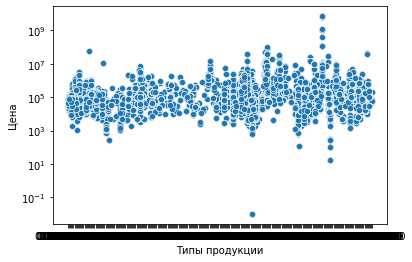

In [107]:
g = sbs.scatterplot(x = ('OKPD'), y = ('total'), data = data)
g.set(yscale = 'log', xlabel = 'Типы продукции', ylabel = 'Цена')

del g
gc.collect()

In [ ]:
len(data['customer_legal_form'].unique())

9

79

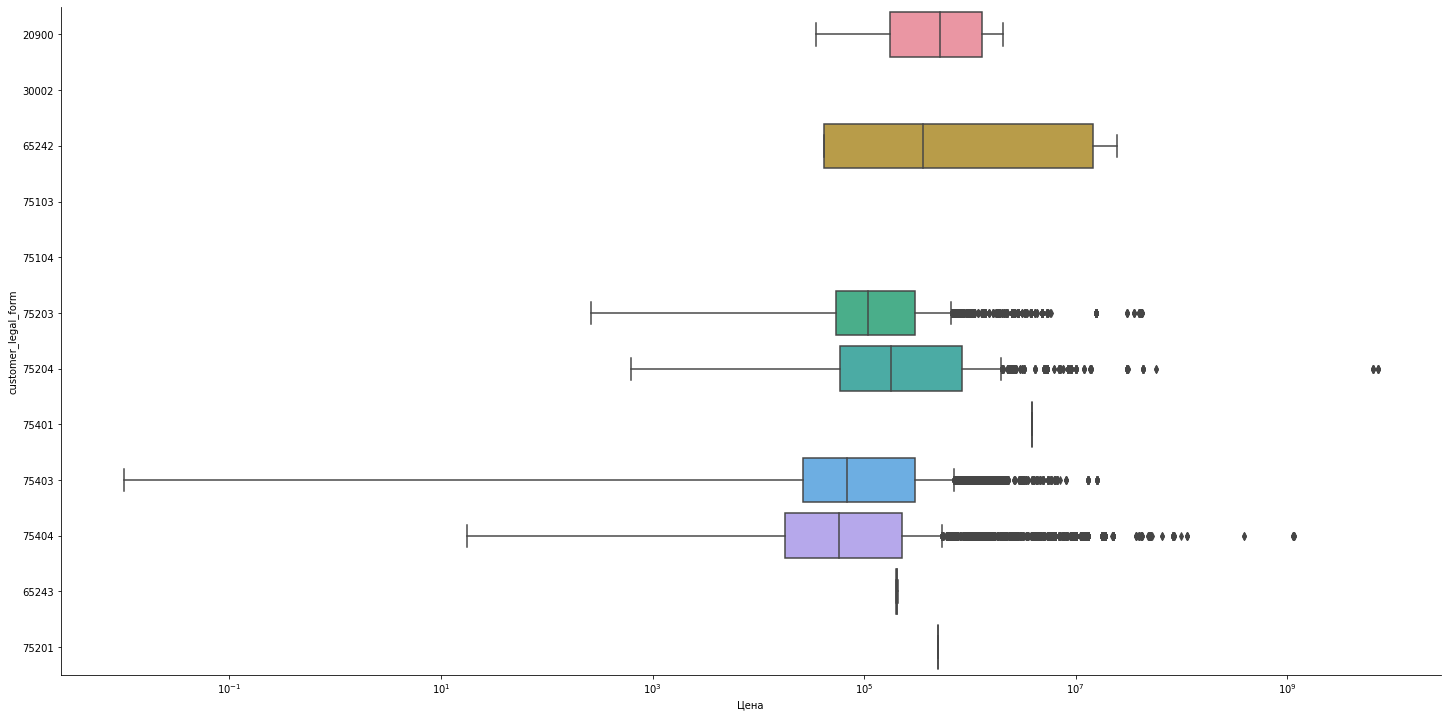

In [ ]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'total'], axis=1).sort_values('customer_legal_form')
  g = sbs.catplot(y = 'customer_legal_form', x = 'total', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'customer_legal_form')
  
del data_to_plot
del g
gc.collect()

# Total:
* count    4.920400e+04
* mean     3.033807e+06
* std      1.161167e+08
* min      1.000000e-02
* 25%      2.800000e+04
* 50%      8.756000e+04
* 75%      2.999925e+05
* max      7.154803e+09

# log(total):
* count    49204.000000
* mean        11.485621
* std          1.919036
* min         -4.605170
* 25%         10.239960
* 50%         11.380080
* 75%         12.611513
* max         22.691050

# XGBoost feature importances
* [0.8741, 'customer_legal_form'],
* [0.0884, 'publicDiscussion'],
* [0.0299, 'plan_number'],
* [0.0054, 'time'],
* [0.0015, 'OKPD'],
* [0.0008, 'isEnergyServiceContract'],
* [0.0, 'positionNumber']

# CatBoost feature importances
* [36.6925, 'OKPD'],
* [34.4718, 'plan_number'],
* [23.376, 'positionNumber'],
* [3.1276, 'customer_legal_form'],
*  [2.2142, 'time'],
* [0.1179, 'publicDiscussion'],
* [0.0, 'isEnergyServiceContract']

#Прогноз цены

In [87]:
cat_var = [
          'plan_number', 
          'customer_legal_form', 
          'positionNumber', 
          'publicDiscussion',
          # 'isEnergyServiceContract',
          'OKPD'
          ]

In [88]:
def errors(model, x_test, y_test):
  y_pred = np.exp(model.predict(x_test))
  y_test = np.exp(y_test)
  accuracy = 0
  for pred, test in zip(y_pred, y_test):
    if np.abs(pred - test)/test <= 0.1:
      accuracy += 1
  print('y_pred:', np.mean(y_pred))
  print('y_test:', np.mean(y_test))
  print("MSE:", metrics.mean_squared_error(y_pred, y_test))
  print("Accuracy:", accuracy/len(y_test))  
  print("MSLE:", metrics.mean_squared_log_error(y_pred, y_test))
  print("RMSLE:", np.sqrt(metrics.mean_squared_log_error(y_pred, y_test)))

In [38]:
print("Кол-во меньше 10ка:",len(data[data['total']<10000]))
print("Процент от меньше 10ка:",len(data[data['total']<10000])/len(data)*100)
print("Больше 100млн:", len(data[data['total']>=100000000]))
print("Процент от больше 100млн:", len(data[data['total']>=100000000])/len(data)*100)

Кол-во меньше 10ка: 5349
Процент от меньше 10ка: 10.871067392894886
Больше 100млн: 27
Процент от больше 100млн: 0.054873587513210316


In [69]:
# data.drop(data[((data['total']<10000) | (data['total']>=100000000))].index, inplace=True)

In [89]:
x = data.drop(['positionCanceled', 'total', 'log_total', 'isEnergyServiceContract'], axis=1)
y = data['log_total']

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [91]:
print(len(x_train))
print(len(y_train))

39363
39363


In [92]:
cat_features = cat_var
model_catboost = CatBoostRegressor(
    n_estimators = 150,
    learning_rate = 0.09,
    max_depth = 10,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
errors(model_catboost, x_test, y_test)

y_pred: 188296.79097084506
y_test: 498594.80300681293
MSE: 3858246580568.4487
Accuracy: 0.0947058225790062
MSLE: 1.6393705982087228
RMSLE: 1.280379083790704


In [94]:
#значимость признаков для леса
importances = model_catboost.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = ['plan_number', 'customer_legal_form', 'positionNumber', 'publicDiscussion', 'time', 'OKPD']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[32.3129, 'OKPD'],
 [24.2822, 'positionNumber'],
 [16.6016, 'plan_number'],
 [16.3216, 'time'],
 [10.4734, 'customer_legal_form'],
 [0.0082, 'publicDiscussion']]

In [ ]:
enc = LabelEncoder()
for param in cat_var:
  x_train.loc[:,param] = enc.fit_transform(x_train[param])
  x_test.loc[:,param] = enc.fit_transform(x_test[param])
x_train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,plan_number,customer_legal_form,positionNumber,publicDiscussion,isEnergyServiceContract,time,OKPD
0,0,7,0,0,0,44,239
1,41,7,183,0,0,31,129
2,37,7,117,0,0,365,56
3,41,7,184,0,0,365,182
4,41,7,183,0,0,31,129


In [ ]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

gc.collect()

498

In [ ]:
len(np.unique(y_train))

2553

In [ ]:
len(np.unique(y_train))

2553

In [ ]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
errors(lin_model, x_test, y_test)

y_pred: 167482.2218925993
y_test: 498594.8030068084
MSE: 4273786195071.787
Accuracy: 0.0458286759475663
MSLE: 3.6236394905063785
RMSLE: 1.9035859556390877


In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000, 
                               bootstrap = True,
                               warm_start = True,
                               oob_score = True)
rf_model.fit(x_train, y_train.ravel())
errors(rf_model, x_test, y_test.ravel())

y_pred: 727892.8903976767
y_test: 498594.8030068084
MSE: 15425819572303.762
Accuracy: 0.036784879585407985
MSLE: 5.559141831218799
RMSLE: 2.3577832451730587


In [ ]:
model = XGBRegressor(seed=42,
                      n_estimators=1000,
                      max_depth=16,
                      learning_rate=0.01)
model.fit(x_train, y_train.ravel())
errors(model, x_test, y_test.ravel())

[19:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
y_pred: 230014.5
y_test: 498594.8030068084
MSE: 4346158613405.03
Accuracy: 0.0373945737221827
MSLE: 4.240312451078501
RMSLE: 2.059201896628522


In [ ]:
#Полиномиальная интерполяция

interpolation = make_pipeline(PolynomialFeatures(4), Ridge())
interpolation.fit(x_train, y_train)
errors(interpolation, x_test, y_test)